# OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction

[kaggle competition site](https://www.kaggle.com/c/stanford-covid-vaccine) 

Dataset description:
- train set:                    2400 examples of length=107 and scoring_length=68
- public test set:              629  examples of length=107 and scoring_length=68 + 3005 examples of length=130 and scoring_length=91
- private leaderboard test set: 3005 examples of length=130 and scoring_length=91 OR same as public test set ????????????????????

### TODO:
- no testing model, one model with different testing and training outputs
- augmentation
- przewidywanie dalszego fragmentu sekwencji na podstawie wczesiejszego fragmentu sekwencji
- GCN
- sequence fragmentation and similarieties finding

## Import section

In [1]:
from IPython.display import Markdown as md

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Concatenate, Lambda, Bidirectional, Dropout, RNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

import spektral
from spektral.layers import GraphConv, GraphAttention, GlobalAttentionPool

import seaborn as sns
import numpy as np
import pandas as pd

from data_preparation import *
from visualization import *
from subgraphing import Subgraphing
from custom_lstm_cell import CustomLSTMCell
from graph_reduce_cell import GraphReduceCell
from submit import *

import time

In [2]:
%load_ext tensorboard

# Data Loading

In [3]:
raw_train_valid_ds, raw_public_test_ds, raw_private_test_ds = get_raw_datasets()

### Data inspection

In [5]:
# print('RAW_TRAIN_VALID_DATASET')
# raw_ds_summary(raw_train_valid_ds)

RAW_TRAIN_VALID_DATASET
EXAMPLES:


,index,id,sequence,structure,adjacency_matrix,edges_features_matrix,predicted_loop_type,signal_to_noise,SN_filter,seq_length,...,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,...,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,...,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,...,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,...,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,...,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173


SIMPLE STATISTICS:


,index,signal_to_noise,SN_filter,seq_length,seq_scored
count,2400.000000,2400.000000,2400.000000,2400.0,2400.0
mean,1199.500000,4.530456,0.662083,107.0,68.0
std,692.964646,2.835142,0.473099,0.0,0.0
min,0.000000,-0.103000,0.000000,107.0,68.0
25%,599.750000,2.391000,0.000000,107.0,68.0
50%,1199.500000,4.442500,1.000000,107.0,68.0
75%,1799.250000,6.294250,1.000000,107.0,68.0
max,2399.000000,17.194000,1.000000,107.0,68.0



POSSIBLE SEQUENCES LENGTHS


,seq_length,seq_scored
0,107,68


In [6]:
# print('RAW_PUBLIC_TEST_DATASET')
# raw_ds_summary(raw_public_test_ds)

RAW_PUBLIC_TEST_DATASET
EXAMPLES:


,index,id,sequence,structure,adjacency_matrix,edges_features_matrix,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
18,18,id_00ca60e44,GGAAAGCAGGAGGCCGAGGAUCCUGCGCUAUGAGGAAACCAUAGAC...,.....((.((.((.((.(((((((((((((((.(....)))))).)...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEESSBSSISSISSISSSSSSSSSSSSSSSBSHHHHSSSSSSBS...,107,68
23,23,id_00e99b69c,GGAAAUUUUAGAUUGCACACAGUCAGGUAGUUAAAAUUAGGCCACC...,..........(((((....)))))((((.(((....(((((........,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEEEEEEESSSSSHHHHSSSSSSSSSISSSIIIISSSSSHHHHH...,107,68



SIMPLE STATISTICS:


,index,seq_length,seq_scored
count,629.000000,629.0,629.0
mean,1798.036566,107.0,68.0
std,1043.635572,0.0,0.0
min,0.000000,107.0,68.0
25%,870.000000,107.0,68.0
50%,1851.000000,107.0,68.0
75%,2683.000000,107.0,68.0
max,3627.000000,107.0,68.0



POSSIBLE SEQUENCES LENGTHS


,seq_length,seq_scored
0,107,68


In [7]:
# print('RAW_PRIVATE_TEST_DATASET')
# raw_ds_summary(raw_private_test_ds)

RAW_PRIVATE_TEST_DATASET
EXAMPLES:


,index,id,sequence,structure,adjacency_matrix,edges_features_matrix,predicted_loop_type,seq_length,seq_scored
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91
5,5,id_002852873,GGAAAGCGAAACGCCGAGAAGACGUAGUUCGCAGAGCGGCGUACCC...,.....(((...(((......(((((((((.((....(((.....))...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEESSSIIISSSBBBBBBSSSSSSSSSBSSBBBBSSSHHHHHSS...,130,91
6,6,id_0031191b7,GGAAAUGUCUACAUAGGAGUGCUGCGGGACGGUAACGUCAUGACCG...,........(((((((((((.((..(((((((....))))....)))...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEEEEESSSSSSSSSSSISSIISSSSSSSHHHHSSSSBBBBSSS...,130,91
7,7,id_003ab2445,GGAAAGACUCAGAGGUGAAGGUCAUCACGGCUGAUAGGAGACUAUC...,.....(((((..........((((((.((.(((((((....)))))...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0,...",EEEEESSSSSBBBBBBBBBBSSSSSSISSISSSSSSSHHHHSSSSS...,130,91



SIMPLE STATISTICS:


,index,seq_length,seq_scored
count,3005.000000,3005.0,3005.0
mean,1820.364725,130.0,91.0
std,1050.480524,0.0,0.0
min,1.000000,130.0,91.0
25%,911.000000,130.0,91.0
50%,1808.000000,130.0,91.0
75%,2732.000000,130.0,91.0
max,3633.000000,130.0,91.0



POSSIBLE SEQUENCES LENGTHS


,seq_length,seq_scored
1,130,91


In [8]:
# sample_submission = get_sample_submission()
# sample_submission

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
457948,id_ffda94f24_125,0.0,0.0,0.0,0.0,0.0
457949,id_ffda94f24_126,0.0,0.0,0.0,0.0,0.0
457950,id_ffda94f24_127,0.0,0.0,0.0,0.0,0.0
457951,id_ffda94f24_128,0.0,0.0,0.0,0.0,0.0


### Error analysis

In below grid of charts, each row represent single random chosen example. Each column is associated with one label (from normal_label_names list and also in the same order).

In each chart:
* black points means example label values for each RNA base
* grey lines means measurement errors

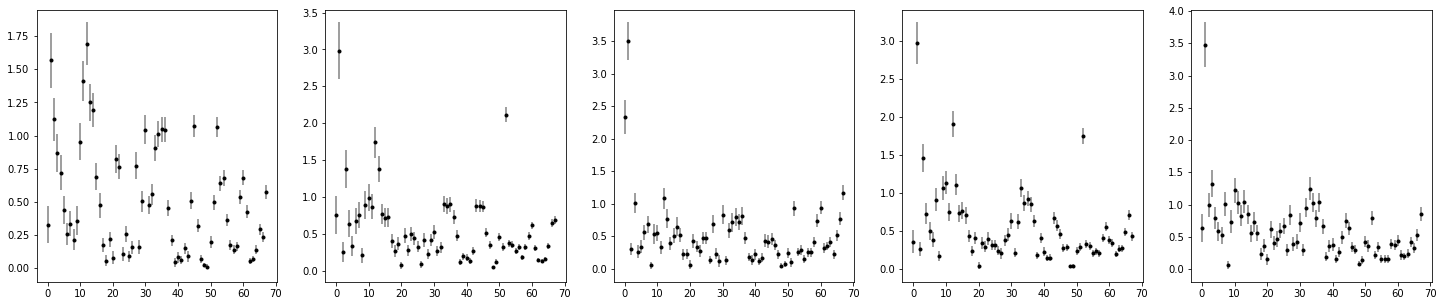

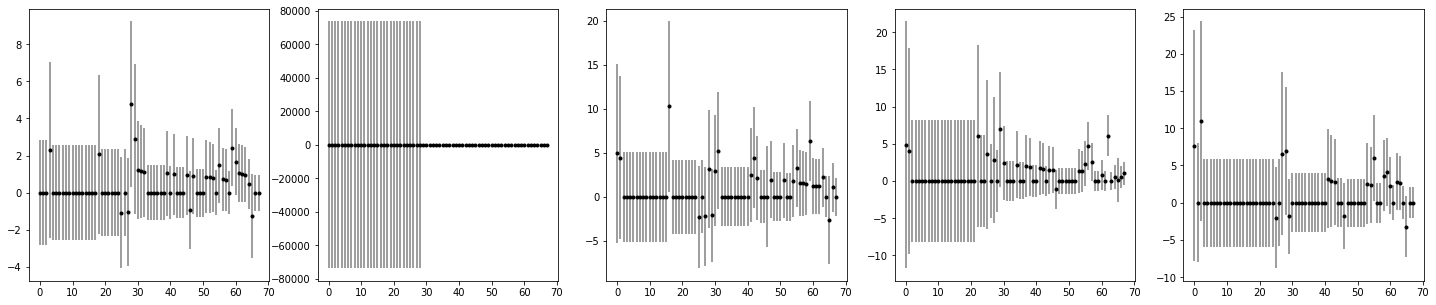

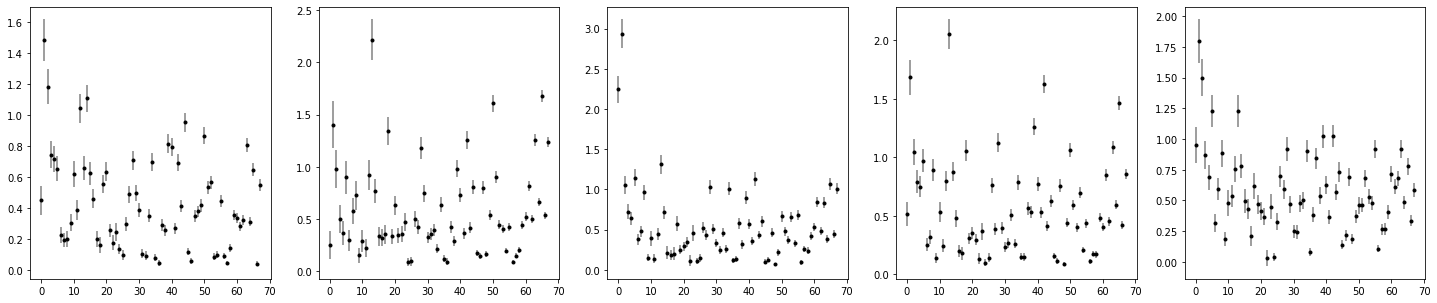

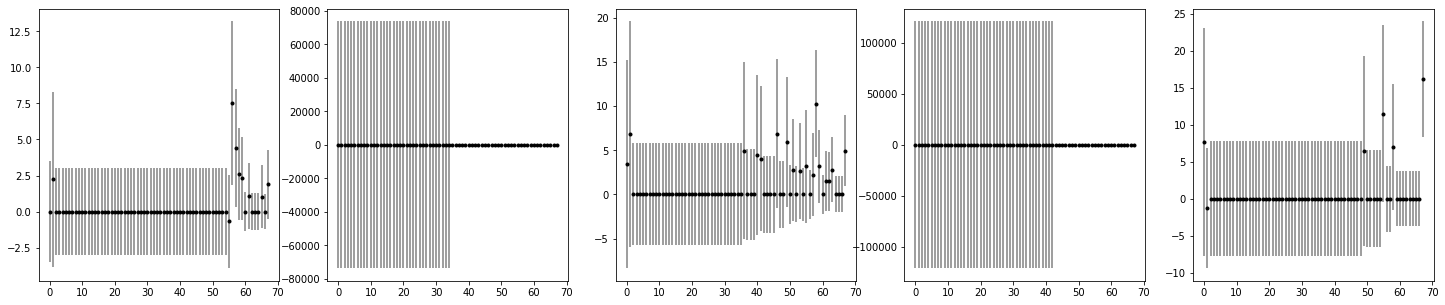

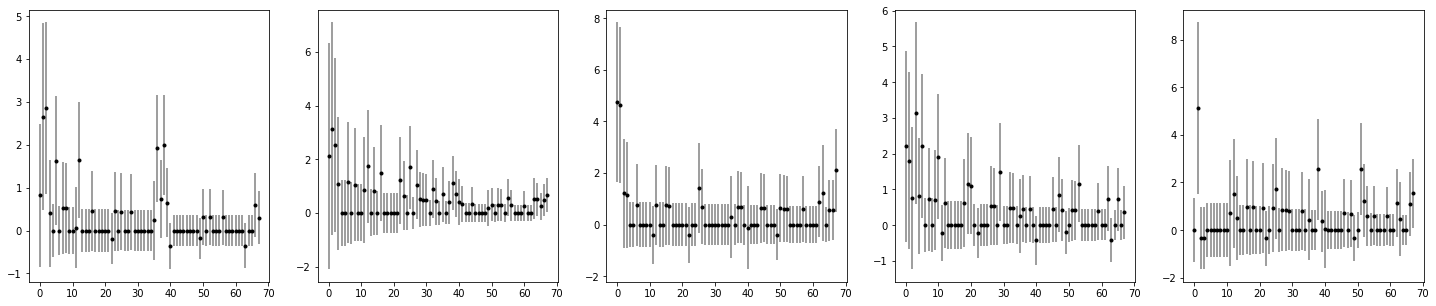

In [8]:
# for i in range(5):
#     visualize_example_errors(raw_train_valid_ds.loc[i])

We can see that some examples have unnormal big measurement errors, so let's see median (not mean, because it's sensitive to outliers) measurements errors for each RNA base in each label across all examples.

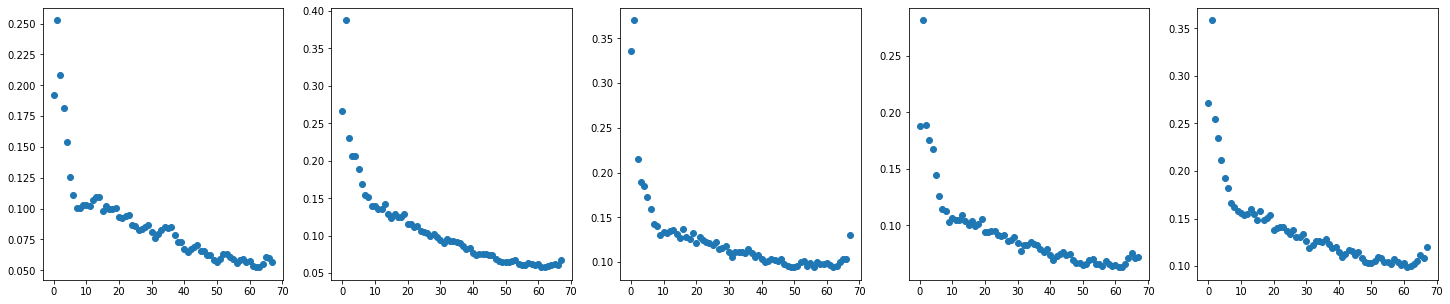

In [9]:
# visualize_median_errors(raw_train_valid_ds)

We can observe that higher index bases have generaly much lower measurement error

To have greater insight in measurement errors for each bases and for each label across all examples let's see histograms (without outliers)

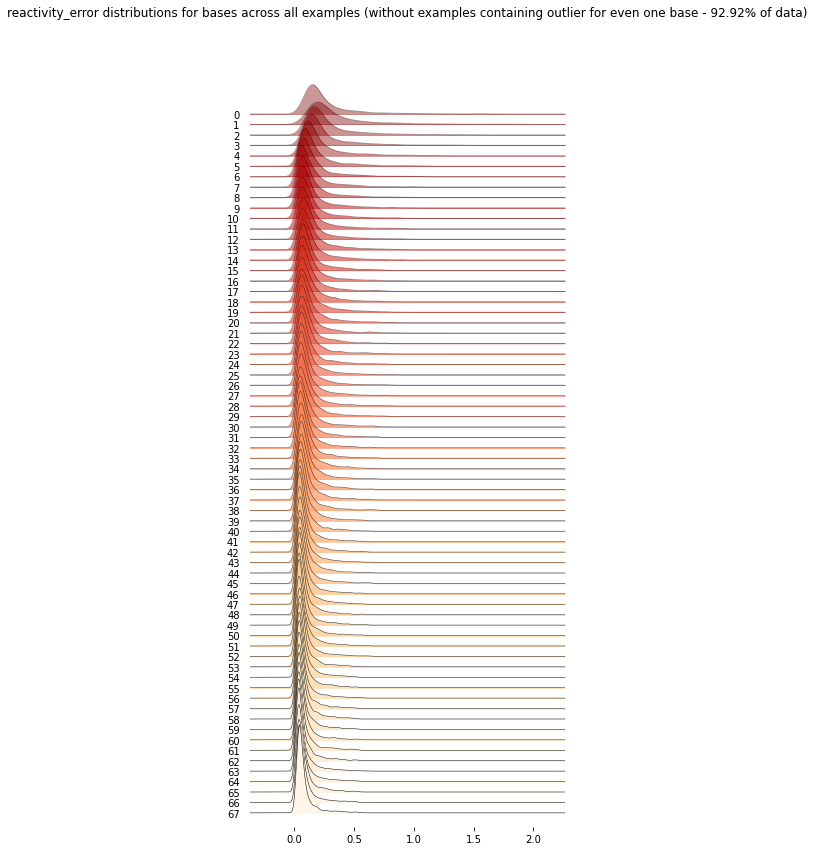

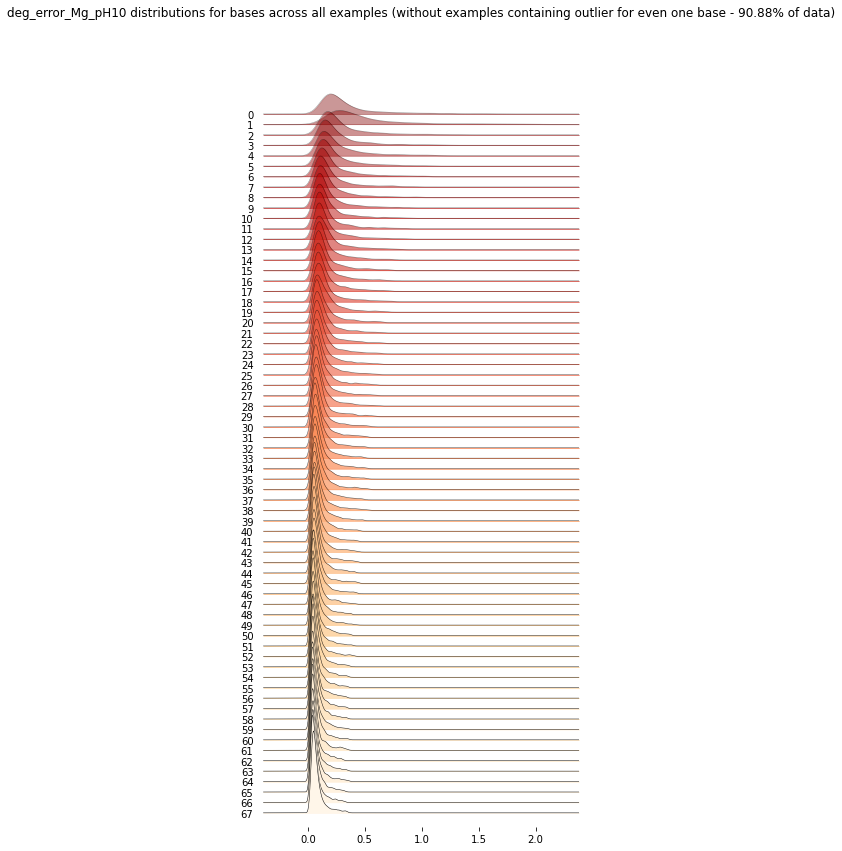

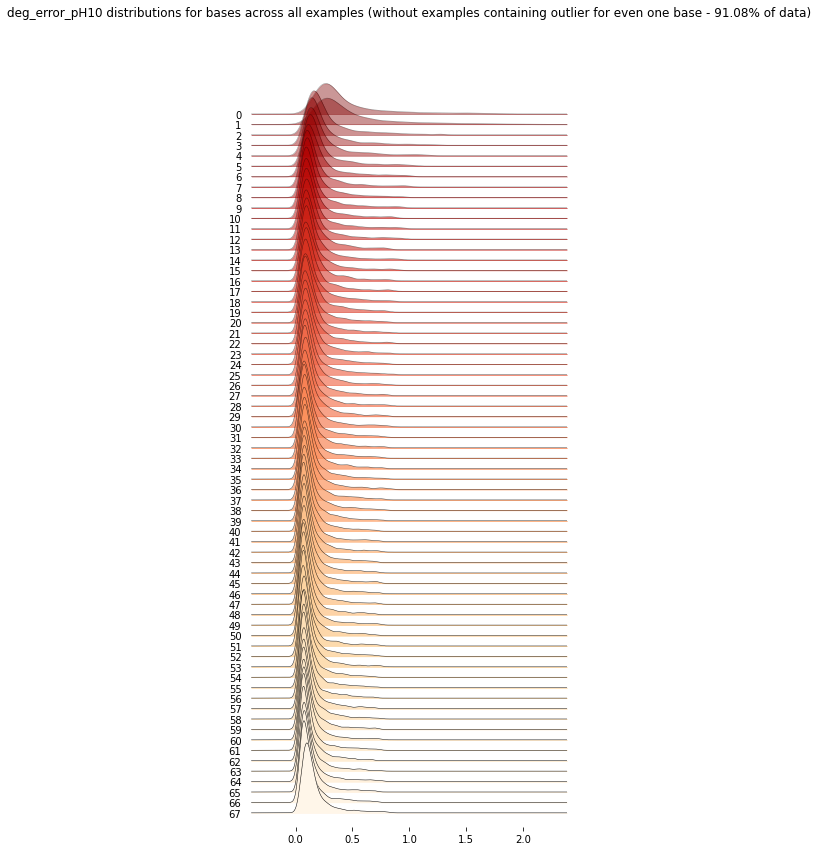

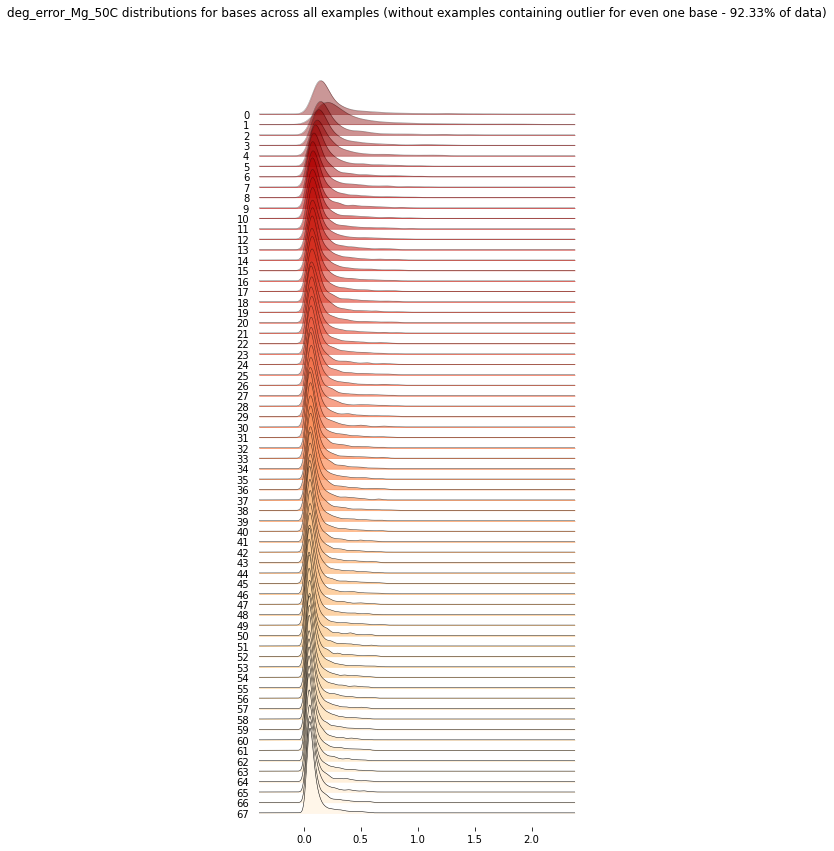

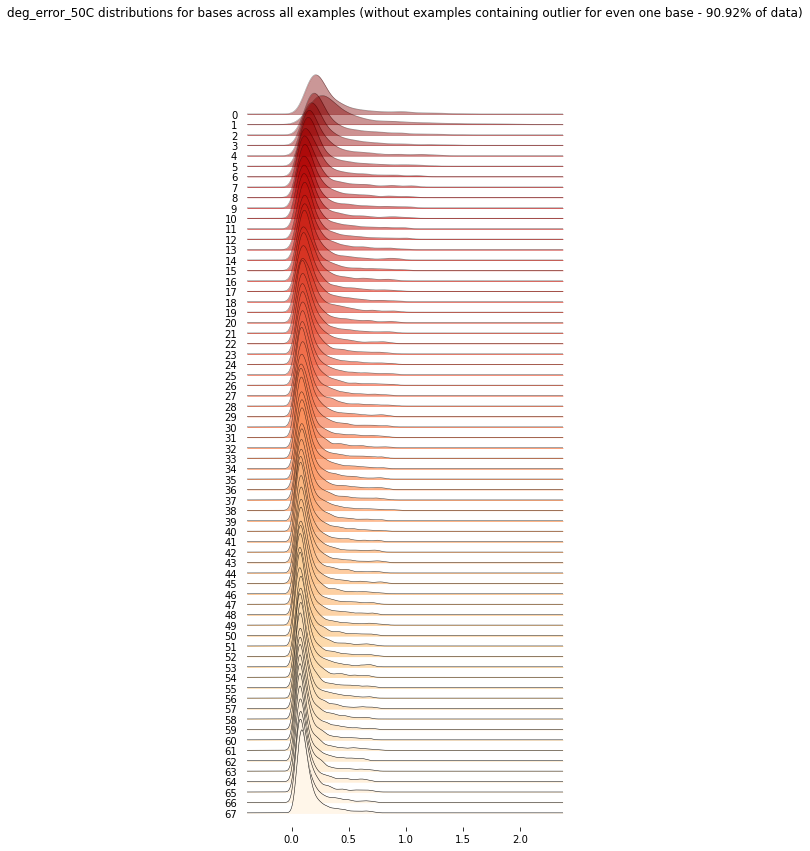

In [10]:
# for error_label_name in ERROR_LABEL_NAMES:
#     column = raw_train_valid_ds[error_label_name]
#     visualize_column_error_label(column, error_label_name)

### Labels analysis

reactivity


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.536378,1.513710,1.124513,0.833669,0.672602,0.458567,0.360533,0.298208,0.292377,0.293193,...,0.320005,0.305114,0.299979,0.306304,0.311137,0.303148,0.334632,0.403904,0.360276,0.324275
std,0.729612,1.266217,1.349776,1.729040,0.689051,0.517758,0.747417,0.672364,0.450488,0.434571,...,0.588476,0.658501,0.735699,0.479715,0.720027,0.707542,0.628050,0.658385,0.648611,0.957559
min,-20.664800,-20.664800,-20.660600,-20.660600,-20.664800,-10.333900,-20.664800,-20.664800,-4.631400,-3.444700,...,-3.444600,-20.664800,-20.664800,-1.879000,-20.664800,-6.889200,-1.367700,-2.583500,-20.664800,-20.664800
25%,0.323375,0.956700,0.845600,0.613825,0.297775,0.110100,0.062375,0.032875,0.028675,0.032075,...,0.041700,0.038450,0.040600,0.029575,0.032400,0.040600,0.037475,0.056200,0.098200,0.109475
50%,0.504150,1.383450,1.154650,0.873850,0.597150,0.333350,0.235750,0.163700,0.179550,0.181450,...,0.200000,0.185450,0.200650,0.154150,0.150250,0.167850,0.203850,0.264150,0.280450,0.235450
75%,0.737650,1.918000,1.456175,1.147125,0.981700,0.725525,0.507100,0.433725,0.424325,0.444050,...,0.489025,0.482675,0.476450,0.472625,0.456850,0.412375,0.485675,0.638125,0.516800,0.412200
max,20.664800,20.666800,20.664800,20.664800,5.167100,5.167100,20.664800,10.333400,4.769700,9.152900,...,20.664800,13.778400,20.664800,10.333900,13.778400,20.664800,20.664800,20.664800,10.333400,20.664800


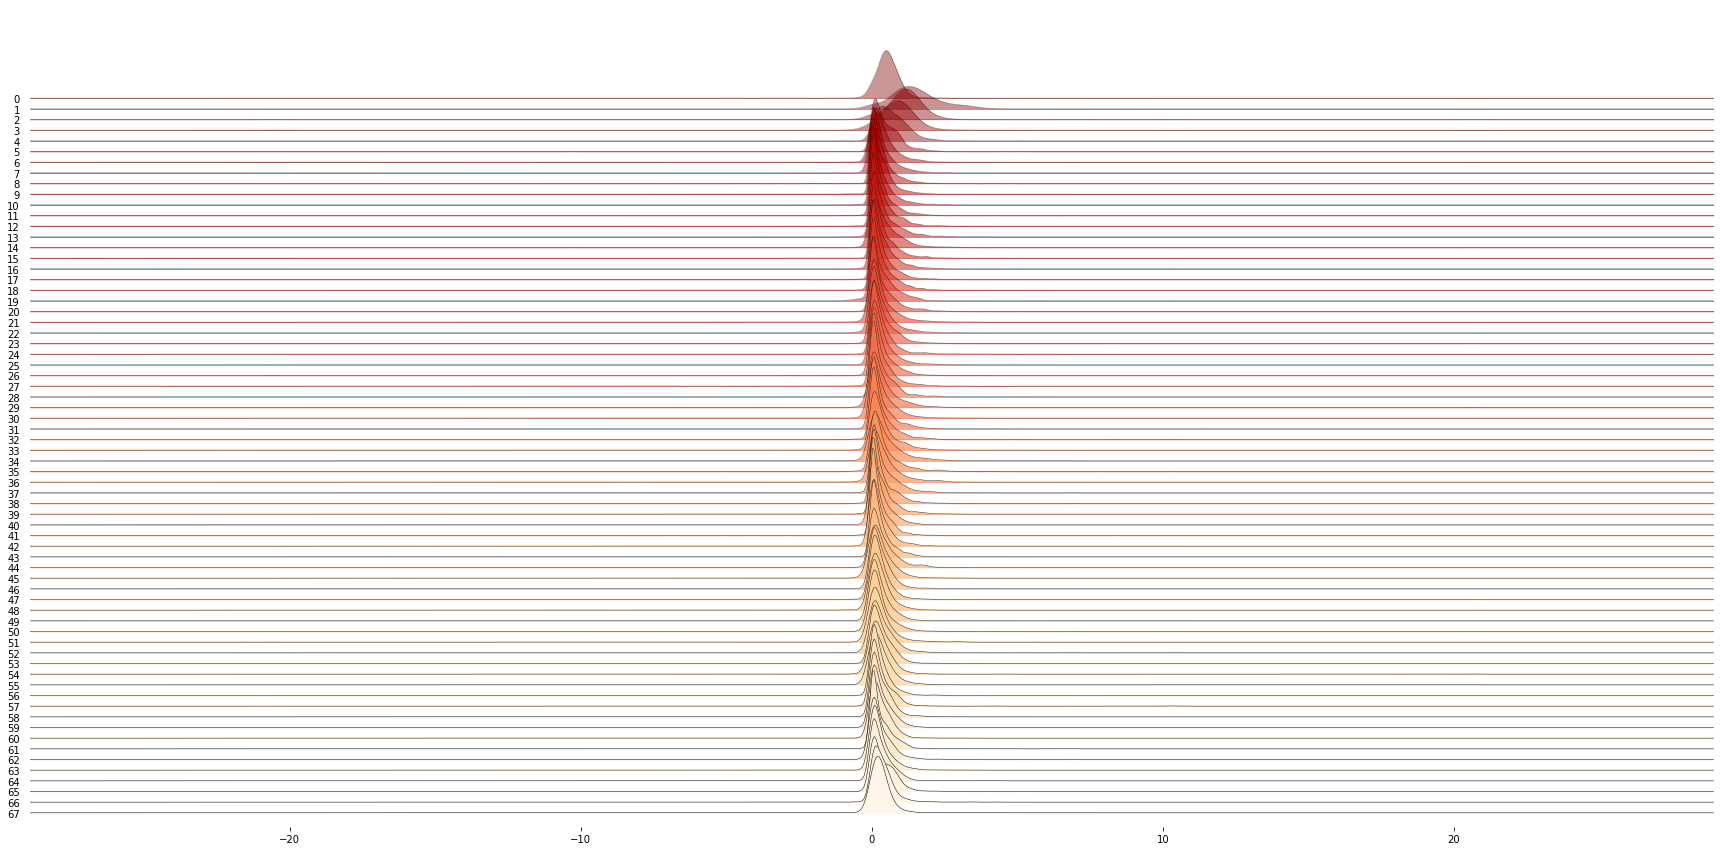

deg_Mg_pH10


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.594784,2.089024,0.722305,0.550928,0.695129,0.589534,0.515086,0.411426,0.428095,0.368775,...,0.437803,0.395689,0.446379,0.426576,0.419822,0.516840,0.597314,0.577760,0.498237,0.673022
std,0.634141,1.445612,0.951488,1.272770,1.044889,0.738532,0.711125,0.751521,0.573831,0.585195,...,0.634314,0.490042,0.690477,0.489091,0.606020,0.633568,0.811998,0.756932,0.599616,0.691804
min,-14.738100,-14.738100,-14.735200,-14.738100,-14.740500,-7.370400,-14.738100,-14.738100,-4.738100,-2.456800,...,-1.473900,-9.824800,-14.738100,-0.685600,-13.264100,-4.913400,-1.842600,-0.781700,-14.738100,-14.738100
25%,0.350075,1.272700,0.351800,0.331525,0.302275,0.219450,0.174875,0.126800,0.128150,0.117775,...,0.137625,0.151325,0.150350,0.160550,0.141650,0.193050,0.201375,0.214600,0.255000,0.365775
50%,0.562200,1.883700,0.703900,0.541000,0.529700,0.448250,0.375650,0.293650,0.290250,0.269650,...,0.279350,0.287350,0.305900,0.293750,0.285950,0.342750,0.373450,0.400750,0.404250,0.574250
75%,0.807500,2.776950,1.030675,0.784225,0.931650,0.837650,0.685650,0.560775,0.580900,0.490425,...,0.566400,0.521250,0.559900,0.533075,0.513175,0.648450,0.685800,0.726300,0.613000,0.860450
max,14.735200,14.739600,14.735200,14.738100,7.370200,14.738100,14.738100,14.739100,4.913400,14.738100,...,14.738100,7.369800,14.739600,7.369800,7.370200,14.740100,14.739600,14.738100,7.369800,7.369800


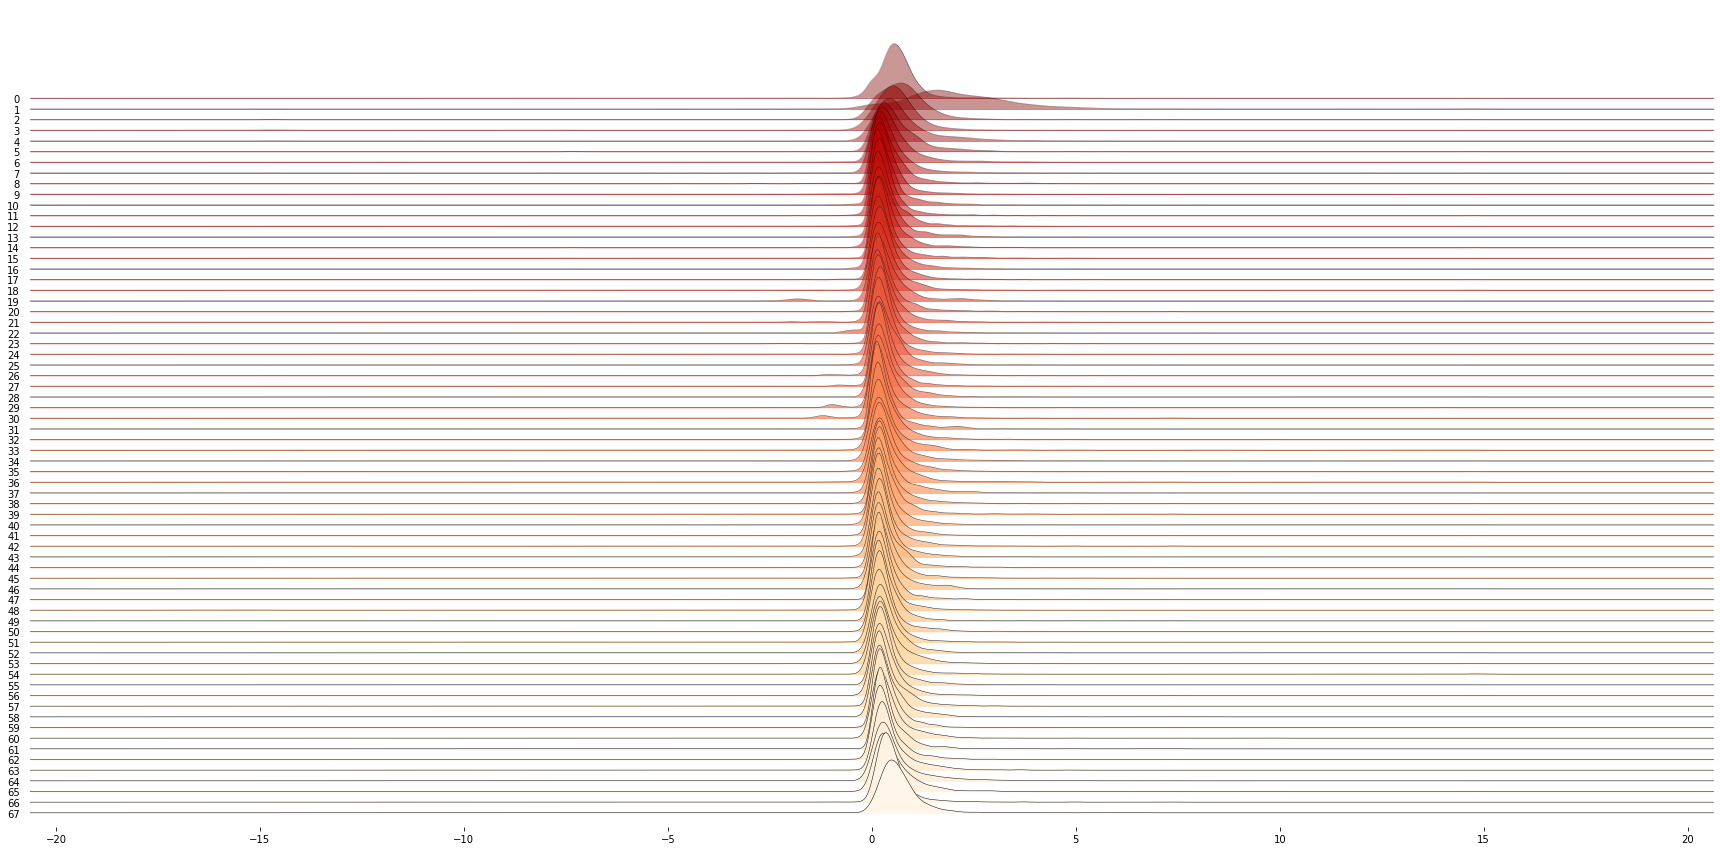

deg_pH10


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,2.005138,2.923601,0.928780,0.722546,0.740868,0.680899,0.571747,0.461096,0.452307,0.409445,...,0.407300,0.394559,0.457730,0.422139,0.432254,0.467999,0.468921,0.467846,0.453545,0.941840
std,1.389639,1.971613,2.163162,3.686616,1.112438,0.744950,1.076637,1.208064,0.658808,1.409217,...,0.612997,1.128074,1.461789,0.959858,1.895334,1.551564,0.707833,0.752139,1.821176,1.996348
min,-44.515300,-44.515300,-44.506400,-44.506400,-44.515300,-22.261000,-44.515300,-44.515300,-8.904500,-7.420500,...,-3.180300,-22.255400,-7.035000,-4.047600,-44.515300,-14.840400,-3.091800,-3.180300,-44.515300,-33.384800
25%,1.623325,2.115600,0.593800,0.491475,0.427400,0.340600,0.246425,0.174750,0.146725,0.120225,...,0.116850,0.121200,0.127375,0.123825,0.121250,0.139875,0.155050,0.169450,0.189300,0.420975
50%,2.031450,2.885650,0.984550,0.701650,0.660500,0.605600,0.466450,0.376300,0.349350,0.271400,...,0.281950,0.268400,0.280000,0.266900,0.268850,0.287900,0.339850,0.353250,0.344900,0.724300
75%,2.476300,3.673350,1.294575,0.978650,0.987975,0.939775,0.789125,0.651800,0.632425,0.523500,...,0.543000,0.538825,0.549200,0.525775,0.509175,0.544675,0.585700,0.598050,0.554525,1.138825
max,14.840400,44.515300,44.515300,44.506400,11.125500,8.904700,4.947000,11.880700,8.098800,44.519700,...,14.840400,44.515300,44.515300,22.259900,44.519700,44.515300,14.840400,14.840400,44.515300,44.519700


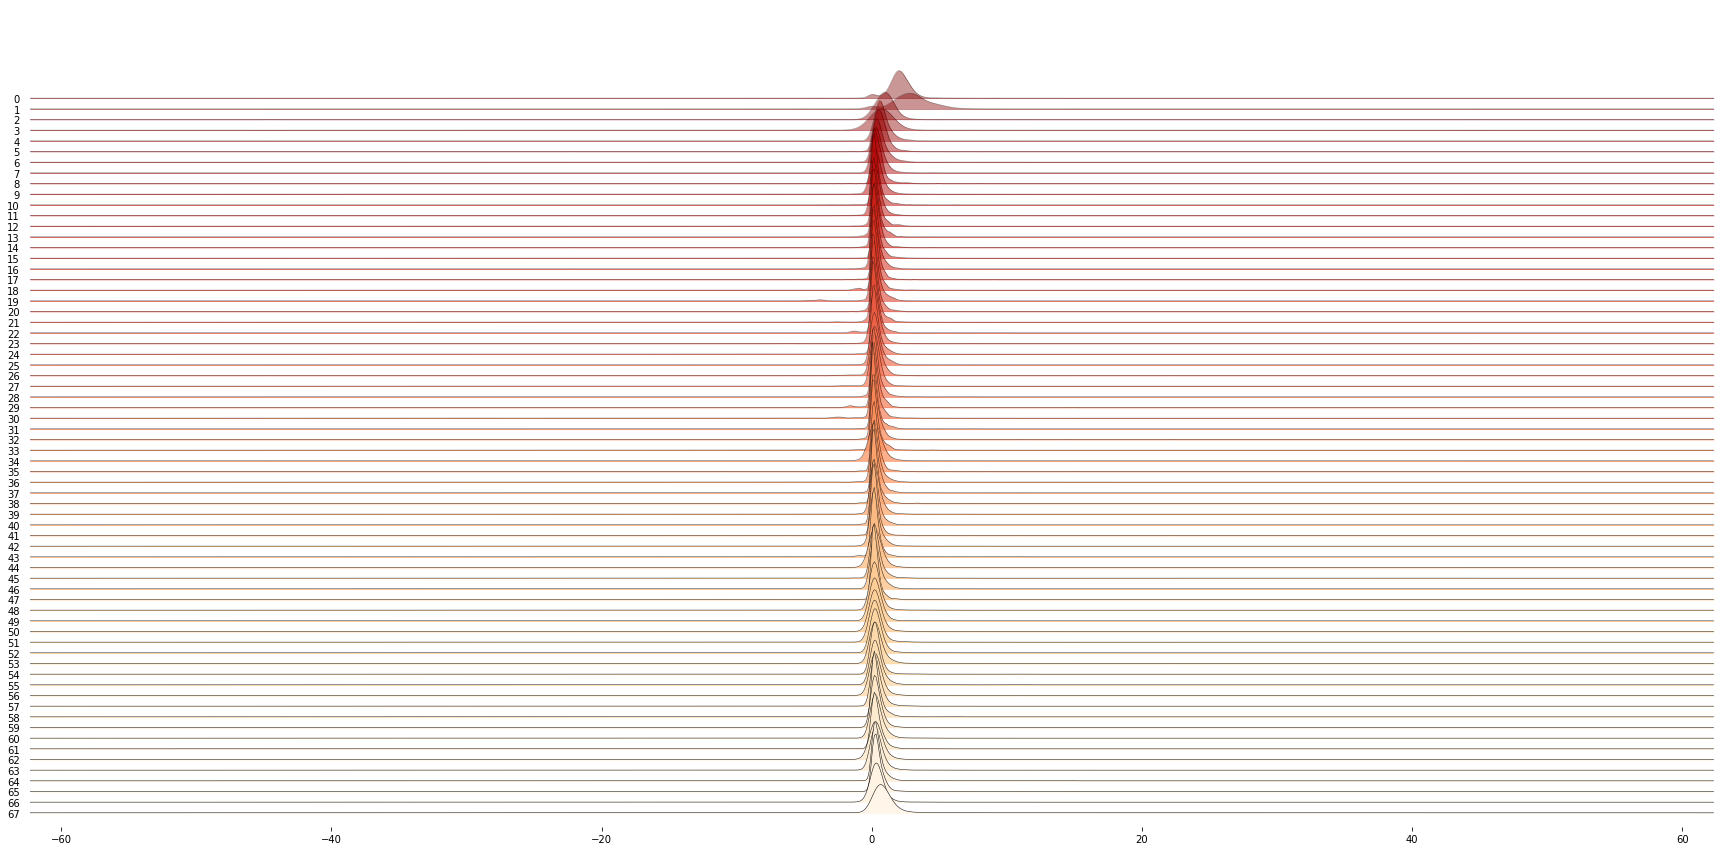

deg_Mg_50C


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.476655,2.033298,0.962429,0.747399,0.856011,0.623050,0.511681,0.432986,0.449736,0.354612,...,0.369458,0.355625,0.385201,0.357709,0.368206,0.480367,0.563445,0.573512,0.501915,0.469470
std,0.817809,1.616327,1.366489,2.102038,1.272135,0.663876,0.807334,0.942428,0.627217,0.492738,...,0.505450,0.755721,0.887452,0.456296,0.722366,0.833200,0.844278,0.702878,1.129472,1.053621
min,-24.252500,-24.252500,-24.247600,-24.252500,-24.252500,-12.128100,-24.252500,-24.252500,-4.851300,-4.042800,...,-4.198100,-24.252500,-24.252500,-2.205200,-20.209700,-8.085200,-0.826900,-3.465200,-24.252500,-24.252500
25%,0.298100,1.249325,0.523250,0.526800,0.381225,0.218450,0.152450,0.090600,0.079300,0.066600,...,0.080600,0.086375,0.077150,0.076950,0.078075,0.114075,0.142050,0.180150,0.222250,0.236100
50%,0.463300,1.839200,0.989600,0.801150,0.685150,0.477400,0.354100,0.289900,0.280450,0.239750,...,0.250450,0.257950,0.249900,0.231050,0.236200,0.296800,0.373250,0.420800,0.404900,0.380900
75%,0.630325,2.739650,1.372250,1.084875,1.097900,0.894625,0.699950,0.626275,0.631800,0.496425,...,0.513325,0.498900,0.528725,0.513975,0.508550,0.632100,0.698575,0.788700,0.607100,0.587000
max,24.247600,24.252500,12.126200,24.252500,24.252500,9.096300,12.127500,24.252500,10.237700,6.064200,...,8.085200,12.127500,24.252500,8.085200,12.128100,24.252500,24.252500,12.127500,24.252500,24.252500


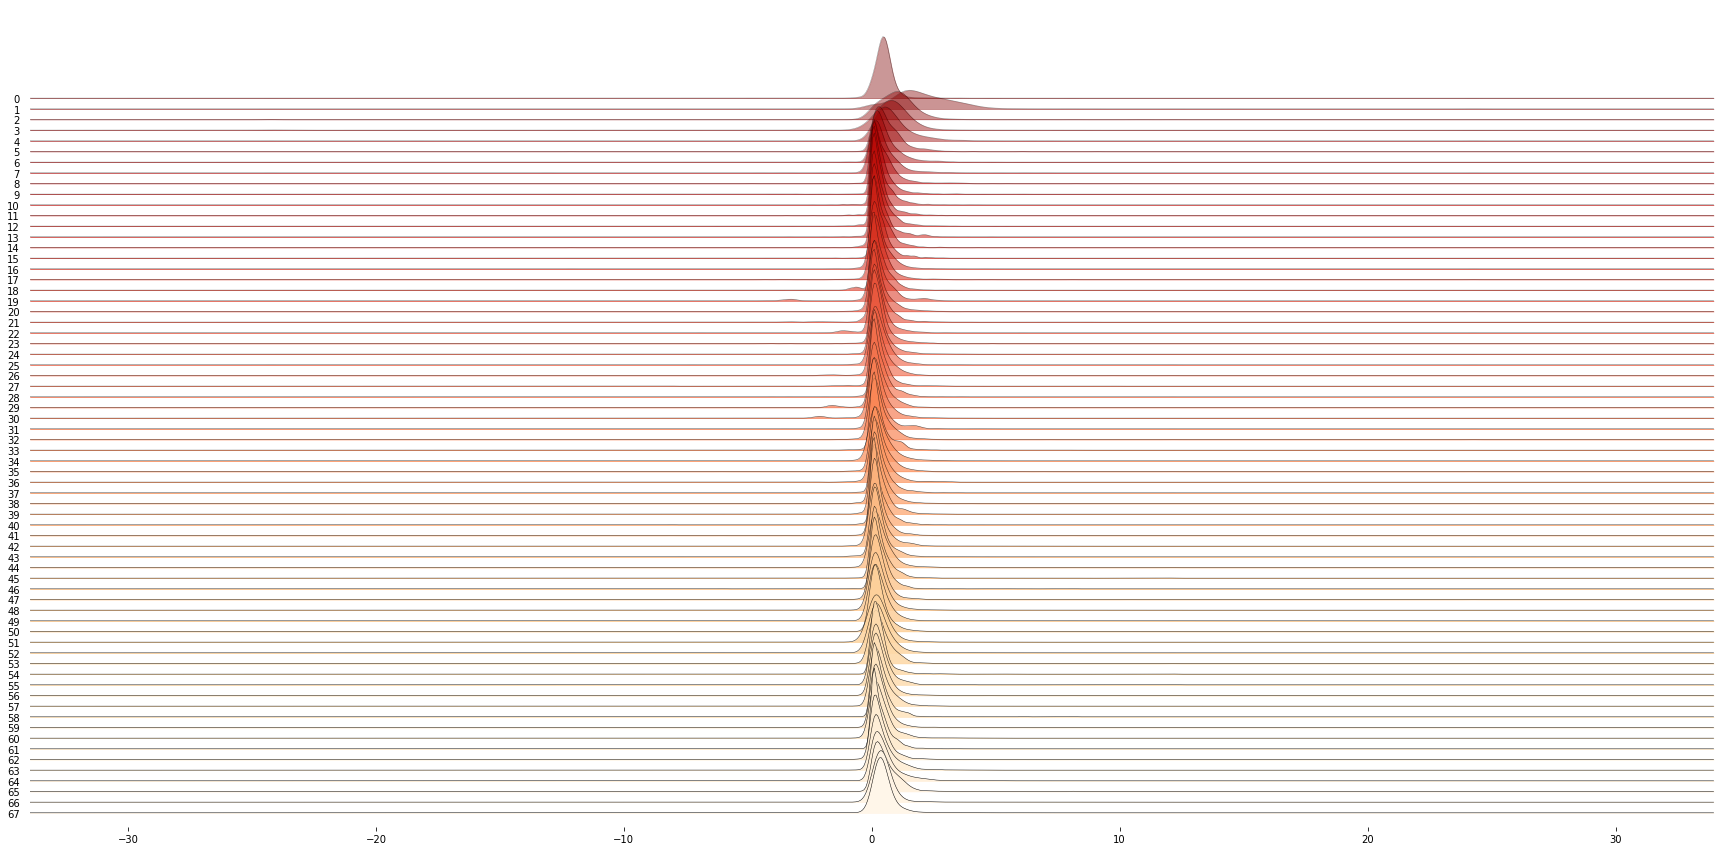

deg_50C


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.612250,1.803313,1.019534,0.765357,0.746606,0.627279,0.562147,0.481785,0.484335,0.433881,...,0.393853,0.349833,0.360787,0.377142,0.391510,0.421597,0.458241,0.533046,0.462601,0.598597
std,0.955351,1.546547,1.921599,2.784339,1.239240,0.666092,1.076317,1.380732,0.742647,0.913521,...,0.945835,0.993586,1.004240,0.653856,1.340709,0.965946,1.253718,1.564194,1.568287,1.984896
min,-38.339900,-38.339900,-38.332300,-38.332300,-38.339900,-19.172900,-38.339900,-38.339900,-6.372400,-6.391100,...,-4.260800,-38.339900,-38.339900,-1.783600,-38.339900,-12.781700,-4.793300,-5.478100,-38.339900,-38.339900
25%,0.428725,1.257350,0.693200,0.590800,0.437250,0.286900,0.192675,0.124375,0.113450,0.098150,...,0.086450,0.088775,0.091575,0.092250,0.098600,0.116050,0.133350,0.180525,0.186450,0.282000
50%,0.630100,1.737450,1.059200,0.864600,0.699400,0.560850,0.446050,0.390200,0.373250,0.303600,...,0.308800,0.284700,0.290100,0.273150,0.288600,0.323200,0.333150,0.383550,0.365250,0.483250
75%,0.819225,2.351400,1.396425,1.138850,1.022000,0.871950,0.826575,0.732525,0.716725,0.643400,...,0.546925,0.520825,0.530650,0.522675,0.554925,0.574275,0.583400,0.646200,0.564400,0.720525
max,7.669200,38.332300,38.339900,38.339900,19.170000,5.899500,19.171900,38.339900,11.502700,34.497600,...,38.339900,9.586800,19.171900,19.173200,38.339900,38.339900,38.339900,38.343800,38.343800,38.343800


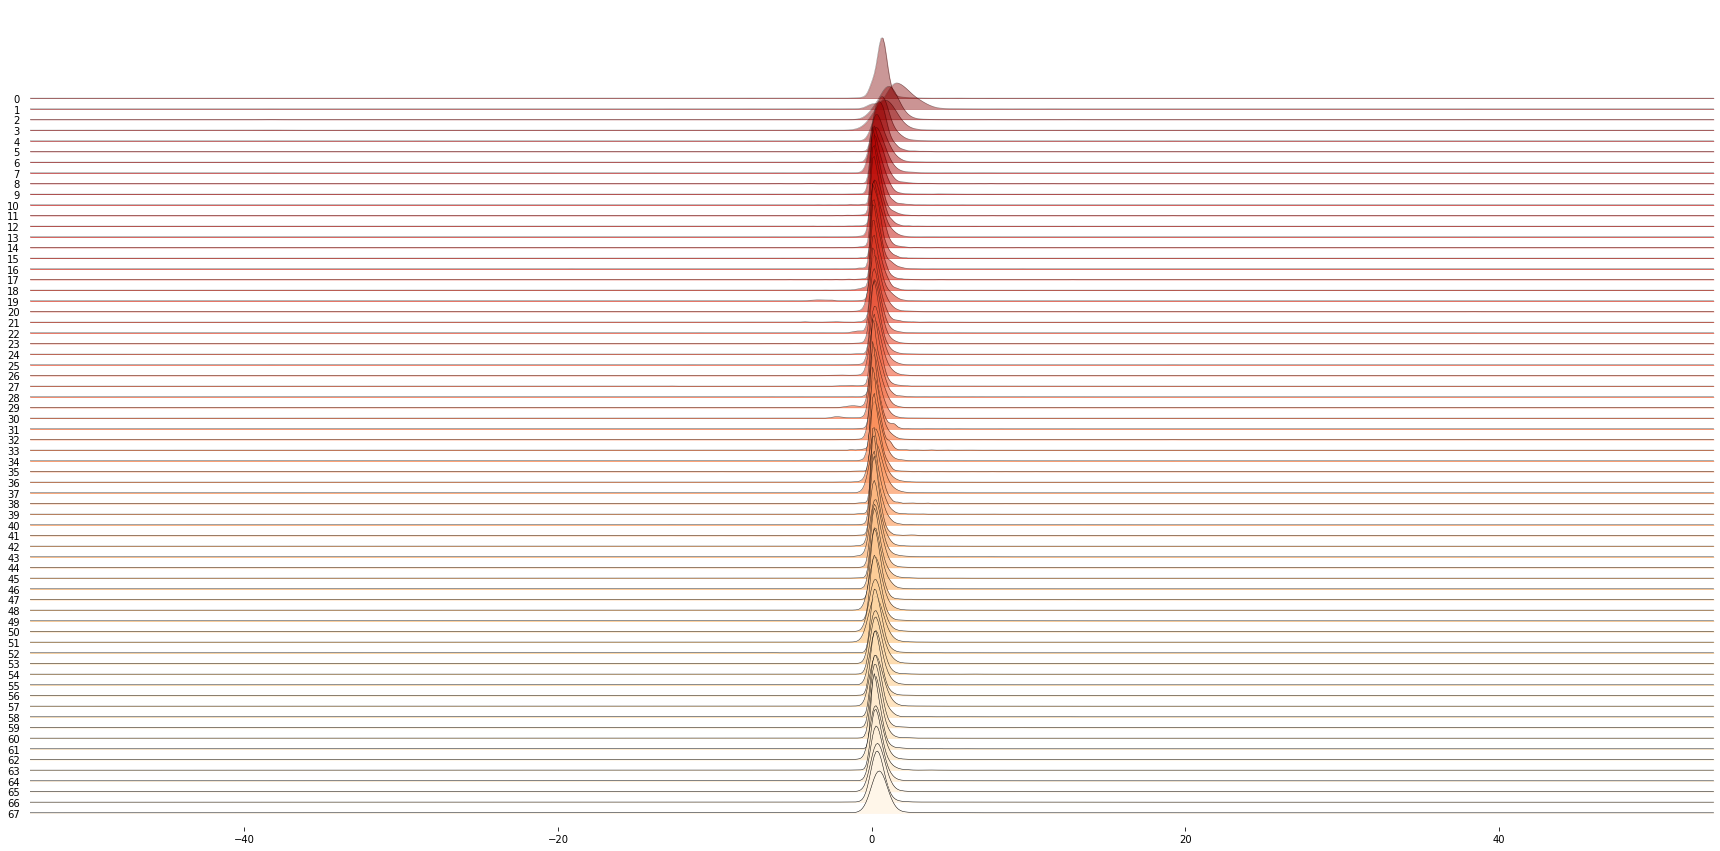

In [11]:
# for normal_label_name in NORMAL_LABEL_NAMES:
#     column = raw_train_valid_ds[normal_label_name]
#     print(f"{normal_label_name}")
#     visualize_column_normal_label(column)

### Raw examples visualization

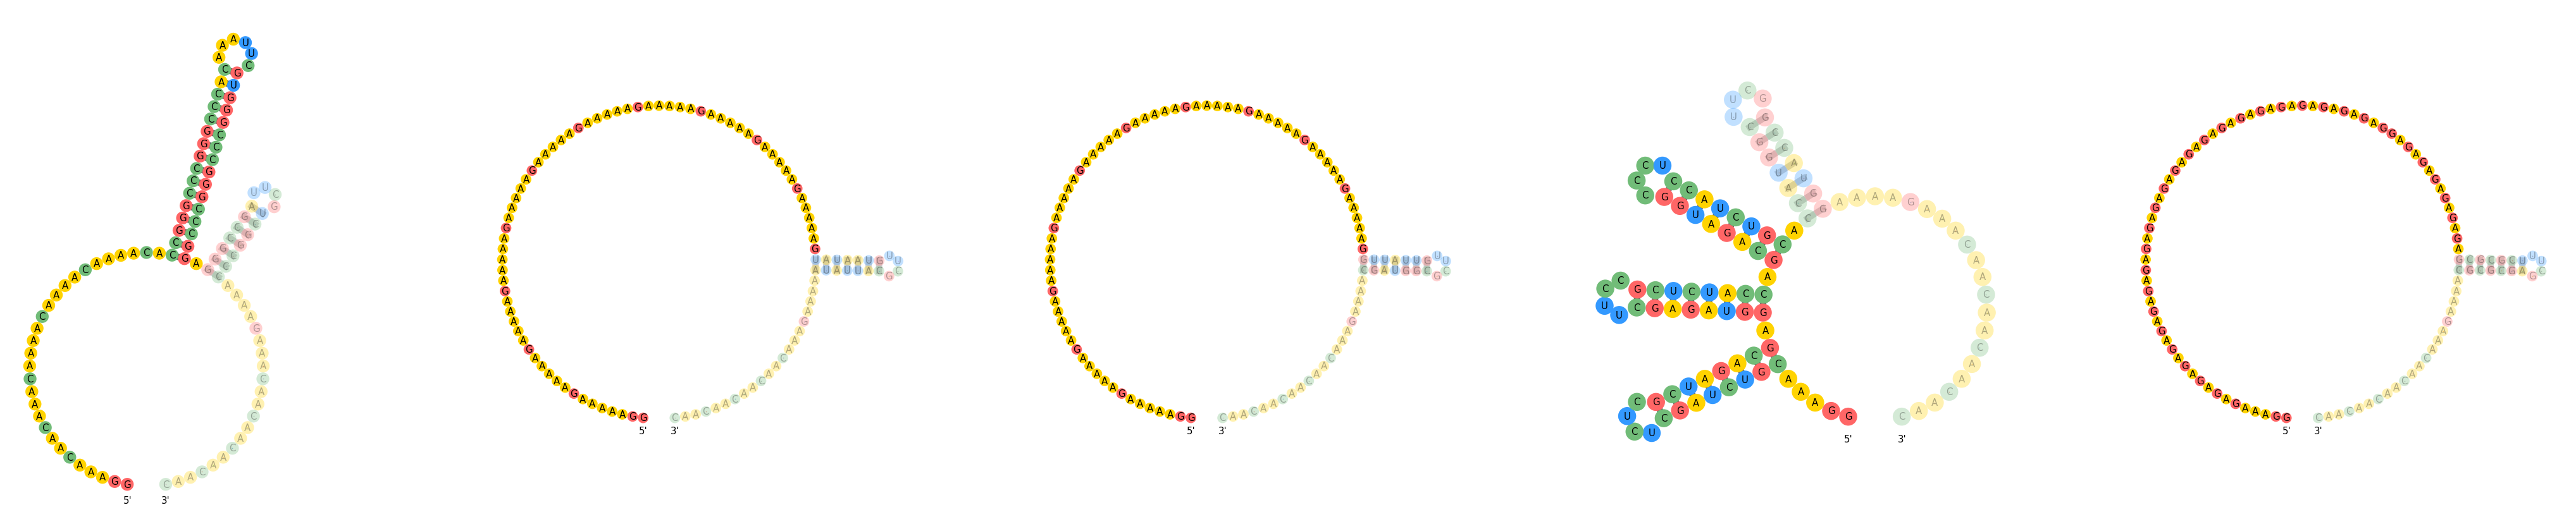

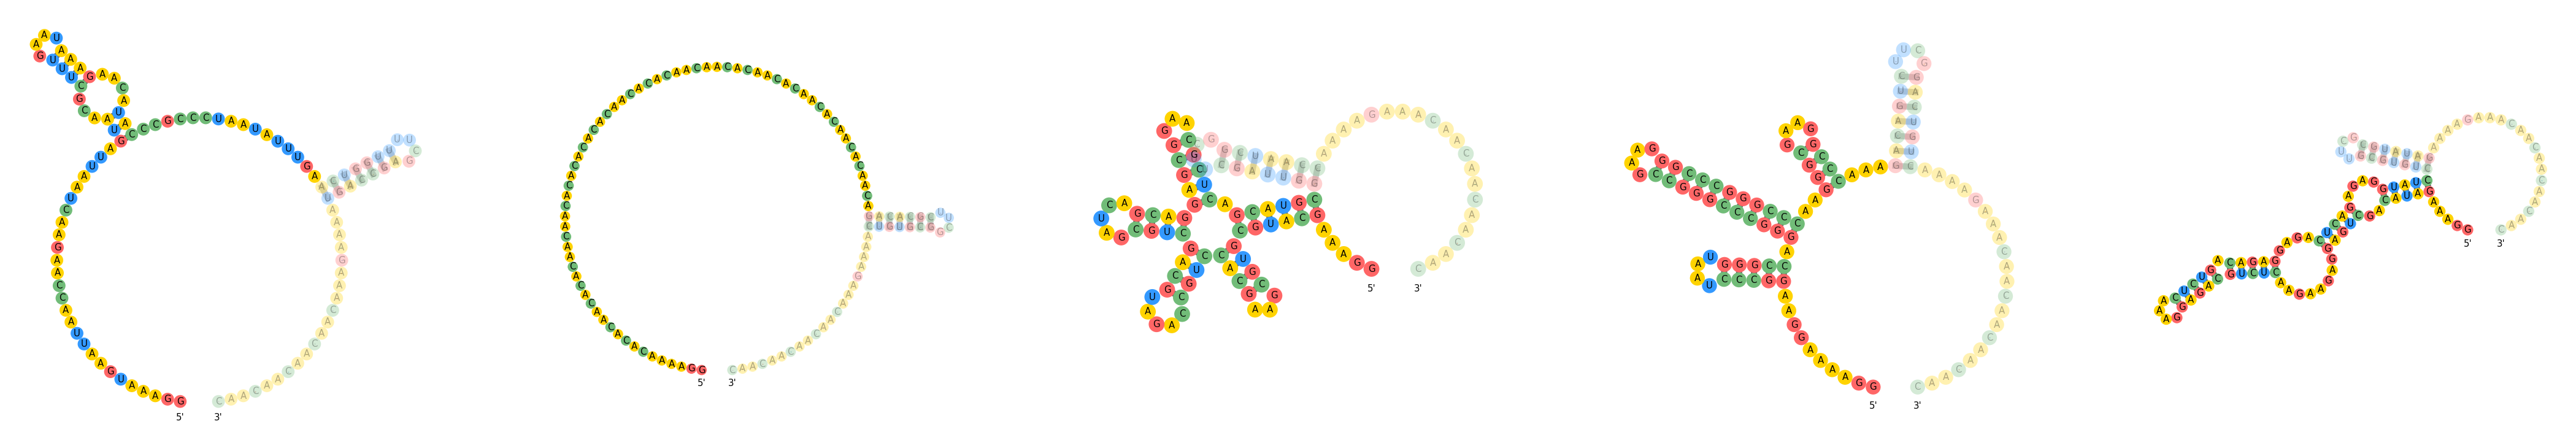

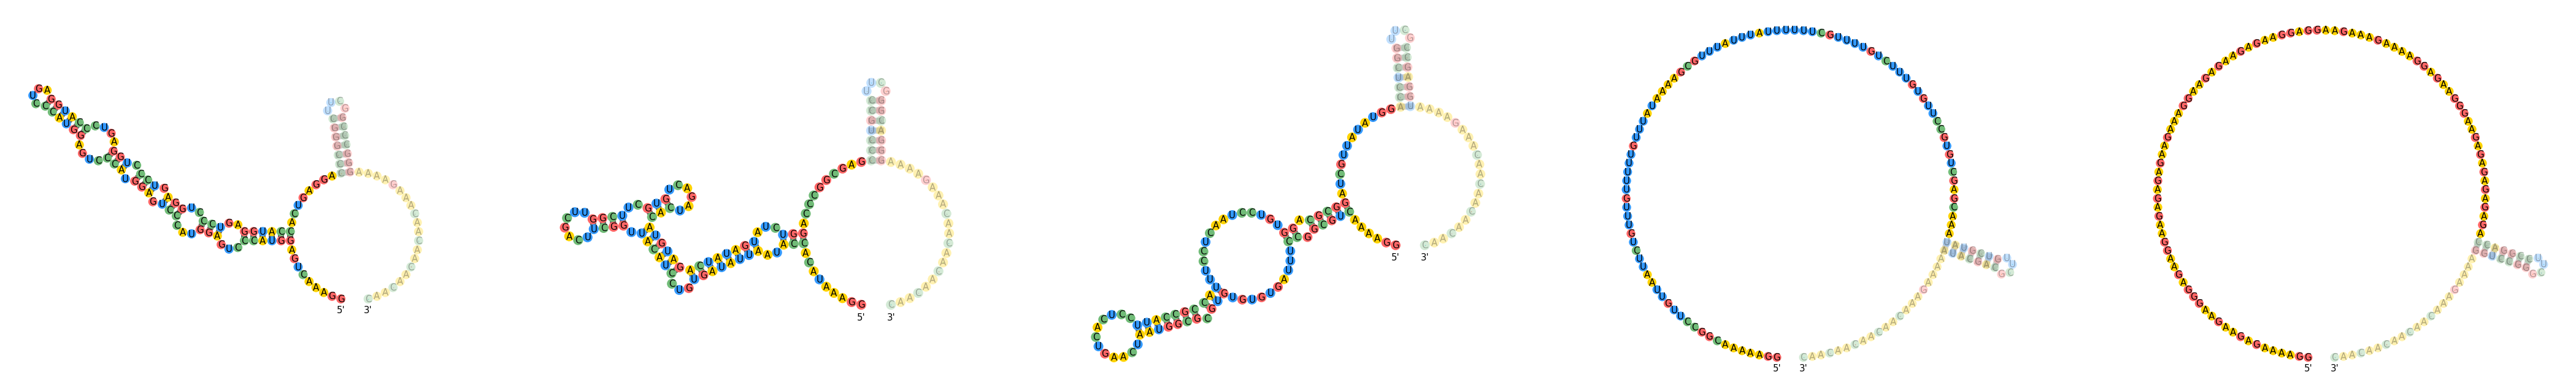

In [12]:
# visualize_random_raw_examples(raw_train_valid_ds)
# visualize_random_raw_examples(raw_public_test_ds)
# visualize_random_raw_examples(raw_private_test_ds)

# Structured tf.data.Dataset construction

In [4]:
train_valid_ds, public_test_ds, private_test_ds = convert_to_datasets(raw_train_valid_ds, raw_public_test_ds, raw_private_test_ds)
# train_valid_ds, public_test_ds, private_test_ds = get_datasets()

### Inspect tf.data.Dataset
Output is quite long so uncomment if needed

In [10]:
# ds_summary(train_valid_ds, 'train_valid_test_ds')

In [11]:
# ds_summary(public_test_ds, 'public_test_ds')

In [12]:
# ds_summary(private_test_ds, 'private_test_ds')

### Inspect tf.data.Dataset's columns

In [5]:
print('train_valid_ds:')
inspect_dataset_columns(train_valid_ds)
print('\n\n\n')

print('public_test_ds:')
inspect_dataset_columns(public_test_ds)
print('\n\n\n')

print('private_test_ds:')
inspect_dataset_columns(private_test_ds)
print('\n\n\n')

train_valid_ds:
FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 68)"
4,edges_features_matrix,"(68, 68, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 14)"



LABELS:


,label_name,tensor_shape
0,stacked_scored_labels,"(68, 3)"


dataset cardinality: 2400




public_test_ds:
FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 68)"
4,edges_features_matrix,"(68, 68, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 14)"


dataset cardinality: 629




private_test_ds:
FEATURES:


,feature_name,tensor_shape
0,sequence,"(91, 4)"
1,structure,"(91, 3)"
2,predicted_loop_type,"(91, 7)"
3,adjacency_matrix,"(91, 91)"
4,edges_features_matrix,"(91, 91, 3)"
5,seq_scored,()
6,stacked_base_features,"(91, 14)"


dataset cardinality: 3005






# Model

In [6]:
print(f"feature_names: {FEATURE_NAMES}")
print(f"error_label_names: {ERROR_LABEL_NAMES}")
print(f"normal_label_names: {NORMAL_LABEL_NAMES}")
print(f"all_label_names: {ALL_LABEL_NAMES}")
print(f"scored_label_names: {SCORED_LABEL_NAMES}")

feature_names: ['sequence', 'structure', 'predicted_loop_type', 'adjacency_matrix', 'edges_features_matrix', 'seq_scored']
error_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
normal_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
all_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
scored_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']


# Old Model

In [18]:
# INPUTS
INPUT_SEQUENCE_LENGTH = None
sequence_input = Input(shape=(INPUT_SEQUENCE_LENGTH,4),
                       name='sequence')
structure_input = Input(shape=(INPUT_SEQUENCE_LENGTH,3),
                        name='structure')
predicted_loop_type_input = Input(shape=(INPUT_SEQUENCE_LENGTH,7),
                                  name='predicted_loop_type')

inputs = [sequence_input, structure_input, predicted_loop_type_input]

# ACTUAL MODEL
# Stack inputs
stacked_inputs = Concatenate(axis=2, name='input_stacking_layer')(inputs)

vectors_sequence = TimeDistributed(Dense(128), name='vectors_expander')(stacked_inputs)

# Encoder
encoder_LSTM = LSTM(256, return_state=True, name='encoder_LSTM')
_, state_h, state_c = encoder_LSTM(vectors_sequence)

# state_h = Dense(256, activation='relu', name='dense_between_1_h')(state_h)
# state_c = Dense(256, activation='relu', name='dense_between_1_c')(state_c)

# state_h = Dense(256, activation='relu', name='dense_between_2_h')(state_h)
# state_c = Dense(256, activation='relu', name='dense_between_2_c')(state_c)

# Decoder
# decoder_LSTM = SequenceGenerator(tf.keras.layers.LSTM(256, name='decoder_LSTM'), seq_len=68, name='decoder')
# decoder_outputs = decoder_LSTM(initial_state=[state_h, state_c])

decoder_LSTM = LSTM(256, name='decoder_LSTM', return_sequences=True)
decoder_outputs = decoder_LSTM(vectors_sequence, initial_state=[state_h, state_c])

# Dense layers
x = TimeDistributed(Dense(256, activation='relu', name='dense_1'))(decoder_outputs)
x = TimeDistributed(Dense(256, activation='relu', name='dense_2'))(x)

# OUTPUTS
reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
# reactivity_error_pred = TimeDistributed(Dense(1), name='reactivity_error')(x)

deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
# deg_error_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_error_Mg_pH10')(x)

# deg_pH10_pred = TimeDistributed(Dense(1), name='deg_pH10')(x)
# deg_error_pH10_pred = TimeDistributed(Dense(1), name='deg_error_pH10')(x)

deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)
# deg_error_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_error_Mg_50C')(x)

# deg_50C_pred = TimeDistributed(Dense(1), name='deg_50C')(x)
# deg_error_50C_pred = TimeDistributed(Dense(1), name='deg_error_50C')(x)


# all_outputs = [reactivity_pred, reactivity_error_pred,
#                deg_Mg_pH10_pred, deg_error_Mg_pH10_pred,
#                deg_pH10_pred, deg_error_pH10_pred,
#                deg_Mg_50C_pred, deg_error_Mg_50C_pred,
#                deg_50C_pred, deg_error_50C_pred]

# submission_required_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred, deg_pH10_pred, deg_50C_pred]

scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
stacked_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)

# TESTING MODEL
testing_model = Model(inputs=inputs, outputs={'stacked_scored_labels': stacked_outputs}, name='testing_model')

# TRAINING MODEL
training_scored_seq_len = 68
# trimmed_stacked_outputs = tf.slice(stacked_outputs, begin=[0,0,0], size=[-1,training_scored_seq_len, -1])
trimmed_stacked_outputs = Lambda(lambda x: x[:,:training_scored_seq_len], name='trimming_layer')(stacked_outputs)
training_model = Model(inputs=inputs, outputs={'stacked_scored_labels': trimmed_stacked_outputs}, name='training_model')

# Graph neural network model

In [7]:
STACKED_FEATURES_SIZE = 14
EDGES_FEATURES_MATRIX_DEPTH = 3
NEIGHBOURHOOD_SIZE = 20
UNITS = 64

In [8]:
def subgraph_dataset(ds):
    def subgraphing_map_fn(*args):
        if len(args) == 2:
            x, y = args
        else:
            x = args[0]

        base_inputs = x['stacked_base_features']
        adjacency_matrix_inputs = x['adjacency_matrix']
        edges_features_matrix_inputs = x['edges_features_matrix']
        inputs = (base_inputs, adjacency_matrix_inputs, edges_features_matrix_inputs)

        subgraphed = Subgraphing(NEIGHBOURHOOD_SIZE)(inputs)

        subgraphed_base_inputs, subgraphed_adjacency_matrix_inputs, subgraphed_edges_features_matrix_inputs = subgraphed
        x['stacked_base_features'] = subgraphed_base_inputs
        x['adjacency_matrix'] = subgraphed_adjacency_matrix_inputs
        x['edges_features_matrix'] = subgraphed_edges_features_matrix_inputs

        if len(args) == 2:
            return x, y
        else:
            return x
    return ds.batch(1).map(subgraphing_map_fn).unbatch().cache()

In [9]:
def create_model_for_subgraphed_dataset(neighbourhood_size, stacked_features_size, edges_features_matrix_depth, units):
    base_inputs = Input(shape = (None, neighbourhood_size, stacked_features_size), name='stacked_base_features')
    adjacency_matrix_inputs = Input(shape=(neighbourhood_size, None, None), name='adjacency_matrix')
    edges_features_matrix_inputs = Input(shape=(neighbourhood_size, None, None, edges_features_matrix_depth), name='edges_features_matrix')

    inputs = (base_inputs, adjacency_matrix_inputs, edges_features_matrix_inputs)

    x = RNN(GraphReduceCell(units), return_sequences=True)(inputs)

    reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
    deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
    deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)

    scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
    stacked_scored_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)
    outputs = {'stacked_scored_labels': stacked_scored_outputs}

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [10]:
model = create_model_for_subgraphed_dataset(NEIGHBOURHOOD_SIZE, STACKED_FEATURES_SIZE, EDGES_FEATURES_MATRIX_DEPTH, UNITS)

Submissions are scored using MCRMSE (mean columnwise root mean squared error):
$\textrm{MCRMSE} = \frac{1}{N_{t}}\sum_{j=1}^{N_{t}}\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{ij} - \hat{y}_{ij})^2}$

In [11]:
def mcrmse(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse, axis=1)

In [12]:
model.compile(loss=mcrmse,
#               optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9),
              optimizer='adam')

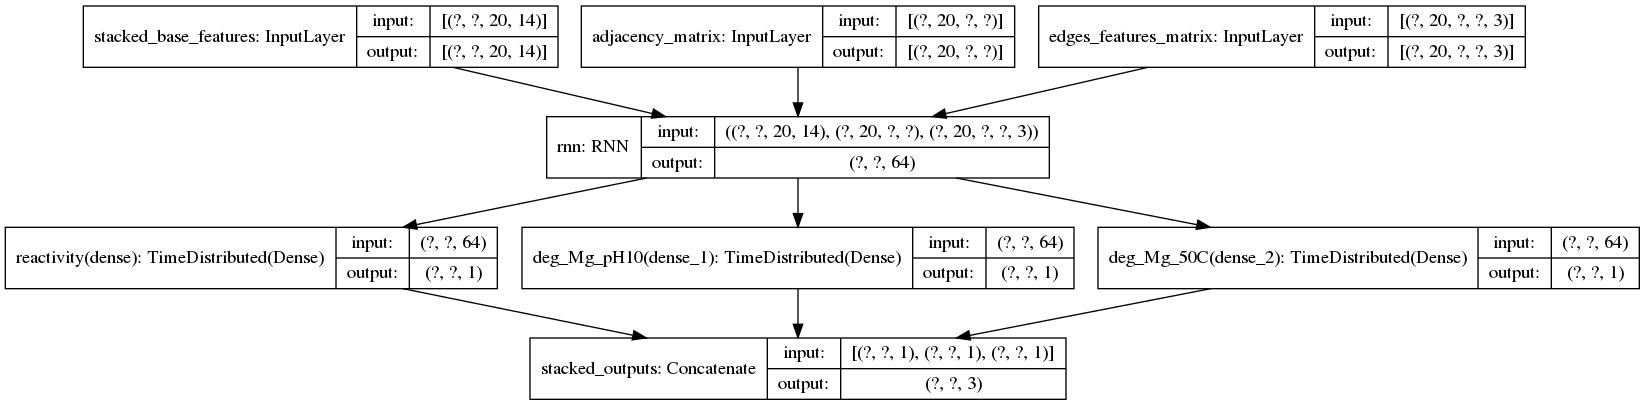

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Additional dataset preparations

Datasets shapes

In [14]:
image_name = 'datasets_shapes.jpg'
md(f"![title]({image_name})")

![title](datasets_shapes.jpg)

In [15]:
train_ds, valid_ds = split_into_train_and_valid(train_valid_ds, split_factor=0.3)

In [16]:
subgraphed_train_ds = subgraph_dataset(train_ds)
inspect_dataset_columns(subgraphed_train_ds)

subgraphed_valid_ds = subgraph_dataset(valid_ds)
inspect_dataset_columns(subgraphed_valid_ds)

subgraphed_public_test_ds = subgraph_dataset(public_test_ds)
inspect_dataset_columns(subgraphed_public_test_ds)

subgraphed_private_test_ds = subgraph_dataset(private_test_ds)
inspect_dataset_columns(subgraphed_private_test_ds)

FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 20, 20)"
4,edges_features_matrix,"(68, 20, 20, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 20, 14)"



LABELS:


,label_name,tensor_shape
0,stacked_scored_labels,"(68, 3)"


dataset cardinality: -2
FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 20, 20)"
4,edges_features_matrix,"(68, 20, 20, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 20, 14)"



LABELS:


,label_name,tensor_shape
0,stacked_scored_labels,"(68, 3)"


dataset cardinality: -2
FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 20, 20)"
4,edges_features_matrix,"(68, 20, 20, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 20, 14)"


dataset cardinality: -2
FEATURES:


,feature_name,tensor_shape
0,sequence,"(91, 4)"
1,structure,"(91, 3)"
2,predicted_loop_type,"(91, 7)"
3,adjacency_matrix,"(91, 20, 20)"
4,edges_features_matrix,"(91, 20, 20, 3)"
5,seq_scored,()
6,stacked_base_features,"(91, 20, 14)"


dataset cardinality: -2


### Baseline training and testing models evaluation

In [17]:
model.evaluate(subgraphed_valid_ds.batch(64))

/home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['sequence', 'structure', 'predicted_loop_type', 'seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


12/12 [==============================] - 21s 2s/step - loss: 0.7125


0.7124933004379272

# Model training

In [21]:
log_dir = os.path.join(os.getcwd(), 'logs')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, update_freq='epoch')

In [23]:
history = model.fit(subgraphed_train_ds.batch(64),
                    validation_data=subgraphed_valid_ds.batch(128),
                    epochs=100,
                    initial_epoch=0,
                    verbose=1,
                    shuffle=True,
                    callbacks=[tensorboard_callback])

Epoch 1/100
      1/Unknown - 0s 137us/step - loss: 0.6876WARNING:tensorflow:From /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
27/27 [==============================] - 53s 2s/step - loss: 0.6051 - val_loss: 0.5669
Epoch 2/100
27/27 [==============================] - 5s 180ms/step - loss: 0.5757 - val_loss: 0.5633
Epoch 3/100
27/27 [==============================] - 5s 182ms/step - loss: 0.5732 - val_loss: 0.5642
Epoch 4/100
27/27 [==============================] - 5s 182ms/step - loss: 0.5729 - val_loss: 0.5640
Epoch 5/100
27/27 [==============================] - 5s 183ms/step - loss: 0.5728 - val_loss: 0.5632
Epoch 6/100
27/27 [==============================] - 5s 182ms/step - loss: 0.5724 - val_loss: 0.5627
Epoch 7/100
27/27 [==============

In [22]:
%tensorboard --logdir $log_dir

Reusing TensorBoard on port 6006 (pid 5692), started 2:20:35 ago. (Use '!kill 5692' to kill it.)

### training and testing model evaluation

In [31]:
model.evaluate(subgraphed_valid_ds.batch(64))

12/12 [==============================] - 1s 44ms/step - loss: 0.5961


0.5961081385612488

### Shape sanity checks

In [24]:
def get_predictions(ds, model):
    prediction_ds = ds.batch(64)
    predictions = model.predict(prediction_ds)['stacked_scored_labels']
    return predictions

In [25]:
predictions_1 = get_predictions(subgraphed_train_ds, model)
print(predictions_1.shape)

(1680, 68, 3)


In [26]:
predictions_3 = get_predictions(subgraphed_public_test_ds, model)
print(predictions_3.shape)

(629, 68, 3)


In [27]:
predictions_5 = get_predictions(subgraphed_private_test_ds, model)
print(predictions_5.shape)

(3005, 91, 3)


### Important Note

Training and testing models share same layers. The difference is that training model has fixed output sequence length (68) due to training - it has to be this.
On the other hand testing model output_sequence length is equal to the input sequence length.
So the training model is used the training and testing model benefits from it. Moreover testing model allows to create submissions.

Submission containes predictions for all positions in sequences. Moreover it contains two parts:
- submission created out of public test set - seqlen: 107, scoring length: 68
- submission created out of private test set - seqlen: 130, scoring length: 91
Testing model is able to create predictions for both public and private test set because it has not set sequence dimension

# Create submission

In [29]:
start = time.time()
submission = create_submission(model, [subgraphed_public_test_ds, subgraphed_private_test_ds], [raw_public_test_ds, raw_private_test_ds])
end = time.time()
print(end - start)
submission

6.061823129653931


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.571527,0.608852,0.0,0.663545,0.0
1,id_00073f8be_1,0.571527,0.608852,0.0,0.663545,0.0
2,id_00073f8be_2,0.571527,0.608852,0.0,0.663545,0.0
3,id_00073f8be_3,0.571527,0.608852,0.0,0.663545,0.0
4,id_00073f8be_4,0.571527,0.608852,0.0,0.663545,0.0
...,...,...,...,...,...,...
316222,id_ffda94f24_86,0.459479,0.535269,0.0,0.559879,0.0
316223,id_ffda94f24_87,0.486060,0.551273,0.0,0.603195,0.0
316224,id_ffda94f24_88,0.486060,0.551273,0.0,0.603195,0.0
316225,id_ffda94f24_89,0.486060,0.551273,0.0,0.603195,0.0


In [30]:
submission_name = 'submission.csv'
submission_path = os.path.join(os.getcwd(), submission_name)
submission.to_csv(submission_path, header=True, index=False)

# Model saving and loading

In [19]:
model_file_name = 'model'
model_path = os.path.join(os.getcwd(), model_file_name)

In [31]:
model = tf.keras.models.load_model(model_path, custom_objects={'mcrmse': mcrmse})

In [32]:
# model.save(model_path)

TODO:
* cross-validation - more data to train
* signal_to_noise parameter - maybe it can be used in some way
* unsupervised pretraining - wuju ogarnia
* SequenceGenerator:
    - propably delete it, but if not:
    - SequenceGenerator wrapper fix get_config
    - SequenceGenerator fix rnn.units handling in case of nested wrapper (e.g. Bidirectional)
    - rewrite